Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [1]:
# Install a pip package in the current Jupyter kernel
import sys

!{sys.executable} -m pip install 'aerosandbox[full]'
!{sys.executable} -m pip install "gymnasium[all]"

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.1.0
    Uninstalling Shimmy-1.1.0:
      Successfully uninstalled Shimmy-1.1.0
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [11]:
import aerosandbox as asb
import aerosandbox.numpy as np
#HYPERPARAMS



In [12]:

import gymnasium as gym
from gymnasium import spaces
import numpy as np
	
class AeroEnv(gym.Env):

	# construct and save self.airplane from self.xsecs
	def constructAirplane(self):
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)

	# construct and safe self.vlm()
	def runAero(self) -> dict[str, any]:
		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		return self.vlm.run()  # Returns a dictionary
		
	def __init__(self, 
			  numChords, #How many independently controlled foils along length of wing 
			  initialYSpacing, #Initial spacing of the cross sections
			  initialChordLength, #Initial length from front to back of each cross section in wing
			  initialUpperKulfan, #Upper kulfan weight initial values (controls curvature of top of wing)
			  initialLowerKulfan, #Lower Kulfan weight initial values (controls curvature of bottom of wing)
			  initialLEW, #Leading edge weight initial values
			  initialN1, #Initial N1 value (forward shift of wing curve shape)
			  initialN2, #Initial N2 value (backwards shift of wing curve shape)
			  dX_bounds, #How much to allow shift of each cross section per time step in forward/backwards direction
			  dY_bounds, #How much to allow shift of each cross section per time step in left/right direction (stubbier wings)
			  dZ_bounds, #How much to allow shift of each cross section per time step in up/down direction (wingtips?)
			  dChord_bounds, #How much to allow each cross section to change in length per timestep (wider wings? front-back length)
			  dTwist_bounds, #How much (in DEGREES) to allow rotation of each cross section per timestep about leading edge
			  KT_bounds, #Min/max upper kulfan weights (should be 0,>0)
			  KB_bounds, #Max lower kulfan weights (should be <0,0 unless you want to create gaps on bottom of wing that arc up)
			  N_bounds, #Bounds of either N value (1, ?)
			  LEW_bounds,
			  kulfanWeightResolution):
		super(AeroEnv, self).__init__()
		self.numChords = numChords
		self.kulfanWeightResolution = kulfanWeightResolution
		
		# Lower and upper bounds for each of the parameters
		low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
		high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
		
		oLow = low.copy() 
		oHigh = high.copy()

		low = np.tile(low, numChords)
		high = np.tile(high, numChords)

		#TODO: Scale the bounds by timesteps to identify max deviation, apply to initial point, and get accurately bounded observation space
		self.observation_space = spaces.Box(low=-100, high=100, shape=(len(low),))
		

		self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		self.vectorLengthPerXSec = len(low)

		
		
		# Initial values for cross sections
		self.init_xyz_le = [[0, i*initialYSpacing, 0] for i in range(self.numChords)]
		self.init_chord = [initialChordLength] * self.numChords  														
		self.init_twist = [0] * self.numChords  														
		self.init_upper_weights = [np.array([initialUpperKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_lower_weights = [np.array([initialLowerKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_leading_edge_weight = [initialLEW] * self.numChords  										
		self.init_N1 = [initialN1] * self.numChords 															
		self.init_N2 = [initialN2] * self.numChords

		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]
		self.constructAirplane()
		
		
		

	def step(self, action):
		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec

			# Apply dX, dY, dZ
			newXYZ_le = [
				self.xsecs[i].xyz_le[0] + action[idx], 		#x + dx
				self.xsecs[i].xyz_le[1] + action[idx + 1],	#y + dy
				self.xsecs[i].xyz_le[2] + action[idx + 2]	#z + dz
			]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(self.kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+self.kulfanWeightResolution + j] for j in range(self.kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*self.kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*self.kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*self.kulfanWeightResolution]					# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le= ([0,0,0] if i == 0 else newXYZ_le),
				chord=newChord,
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)

		self.constructAirplane()
		aero = self.runAero()

		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		
		obs = [liftCoeff, dragCoeff]
		reward = liftCoeff/dragCoeff
		terminated = bool(reward >= 120)
		truncated = bool(reward >= 120)
		info = {"lift": liftCoeff, "drag": dragCoeff}

		return obs, reward, terminated, truncated, info #last array here is the info object
    # observation (ObsType): An element of the environment's observation_space as the next observation due to the agent actions.
    # reward (SupportsFloat): The reward as a result of taking the action.
    # terminated (bool): Whether the agent reaches the terminal state (as defined under the MDP of the task)
    # truncated (bool): Whether the truncation condition outside the scope of the MDP is satisfied.
    # info (dict): Contains auxiliary diagnostic information (helpful for debugging, learning, and logging).
	
	def reset(self, seed=123):
		super().reset(seed=seed)
		# Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]

		self.airplane = asb.Airplane(
			name="TestPlane(JustWings)",
			xyz_ref=[0, 0, 0],
			wings=[
				asb.Wing(
					name="Wing",    
					symmetric=True,            
					xsecs=self.xsecs
				),
			],
		)

		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		aero = self.vlm.run()
		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		
		return [liftCoeff, dragCoeff], {"lift": liftCoeff, "drag": dragCoeff} 
	
	def render(self):
		self.vlm.run()
		self.airplane.draw_three_view()
		self.vlm.draw()
	
	def close (self):
		...

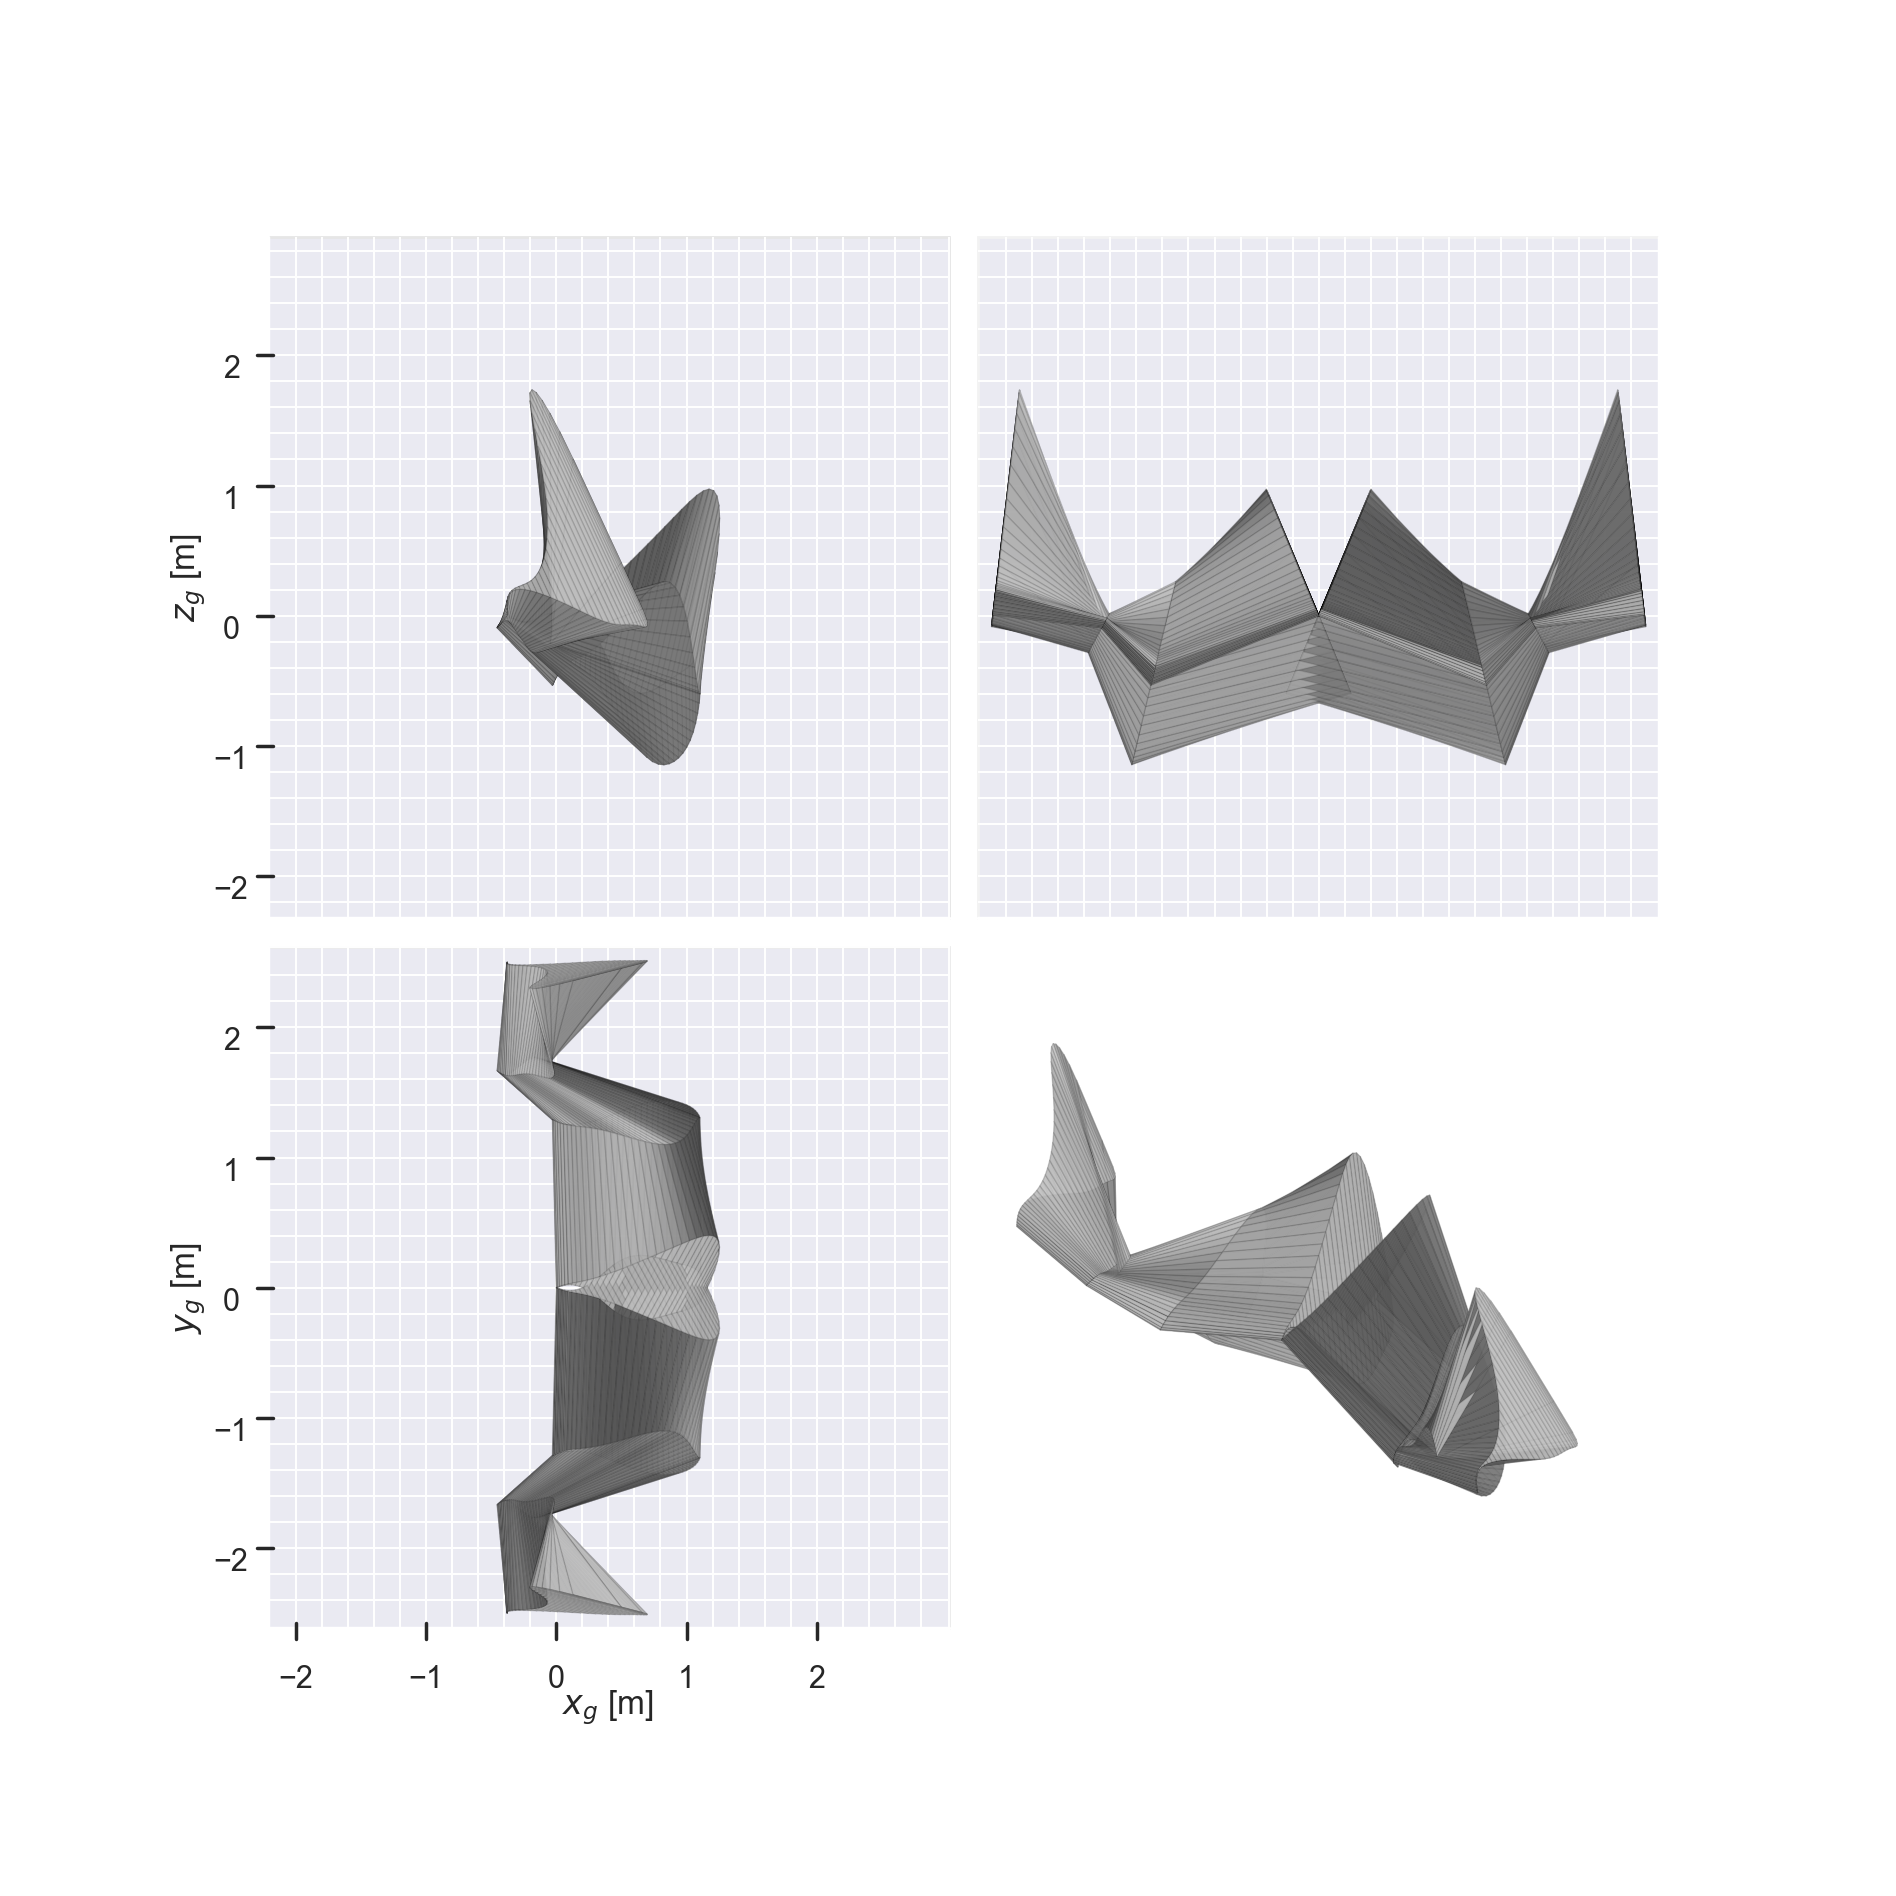

/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


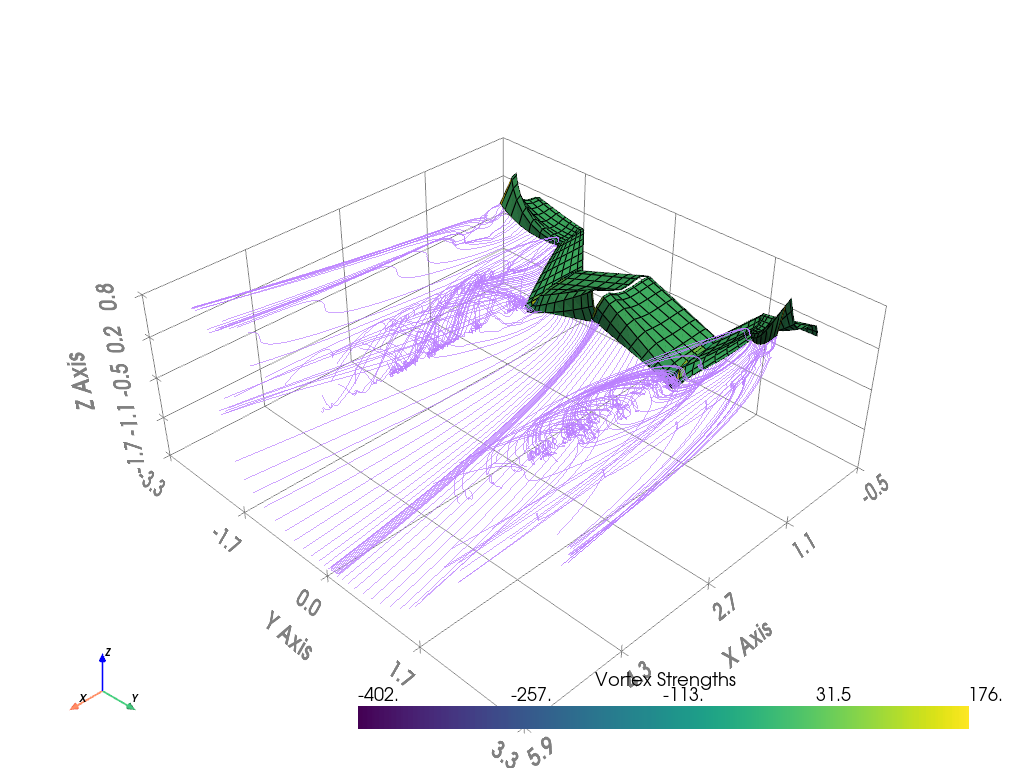

([1.5033527615595192, 0.18080348661436405], {'lift': 1.5033527615595192, 'drag': 0.18080348661436405})


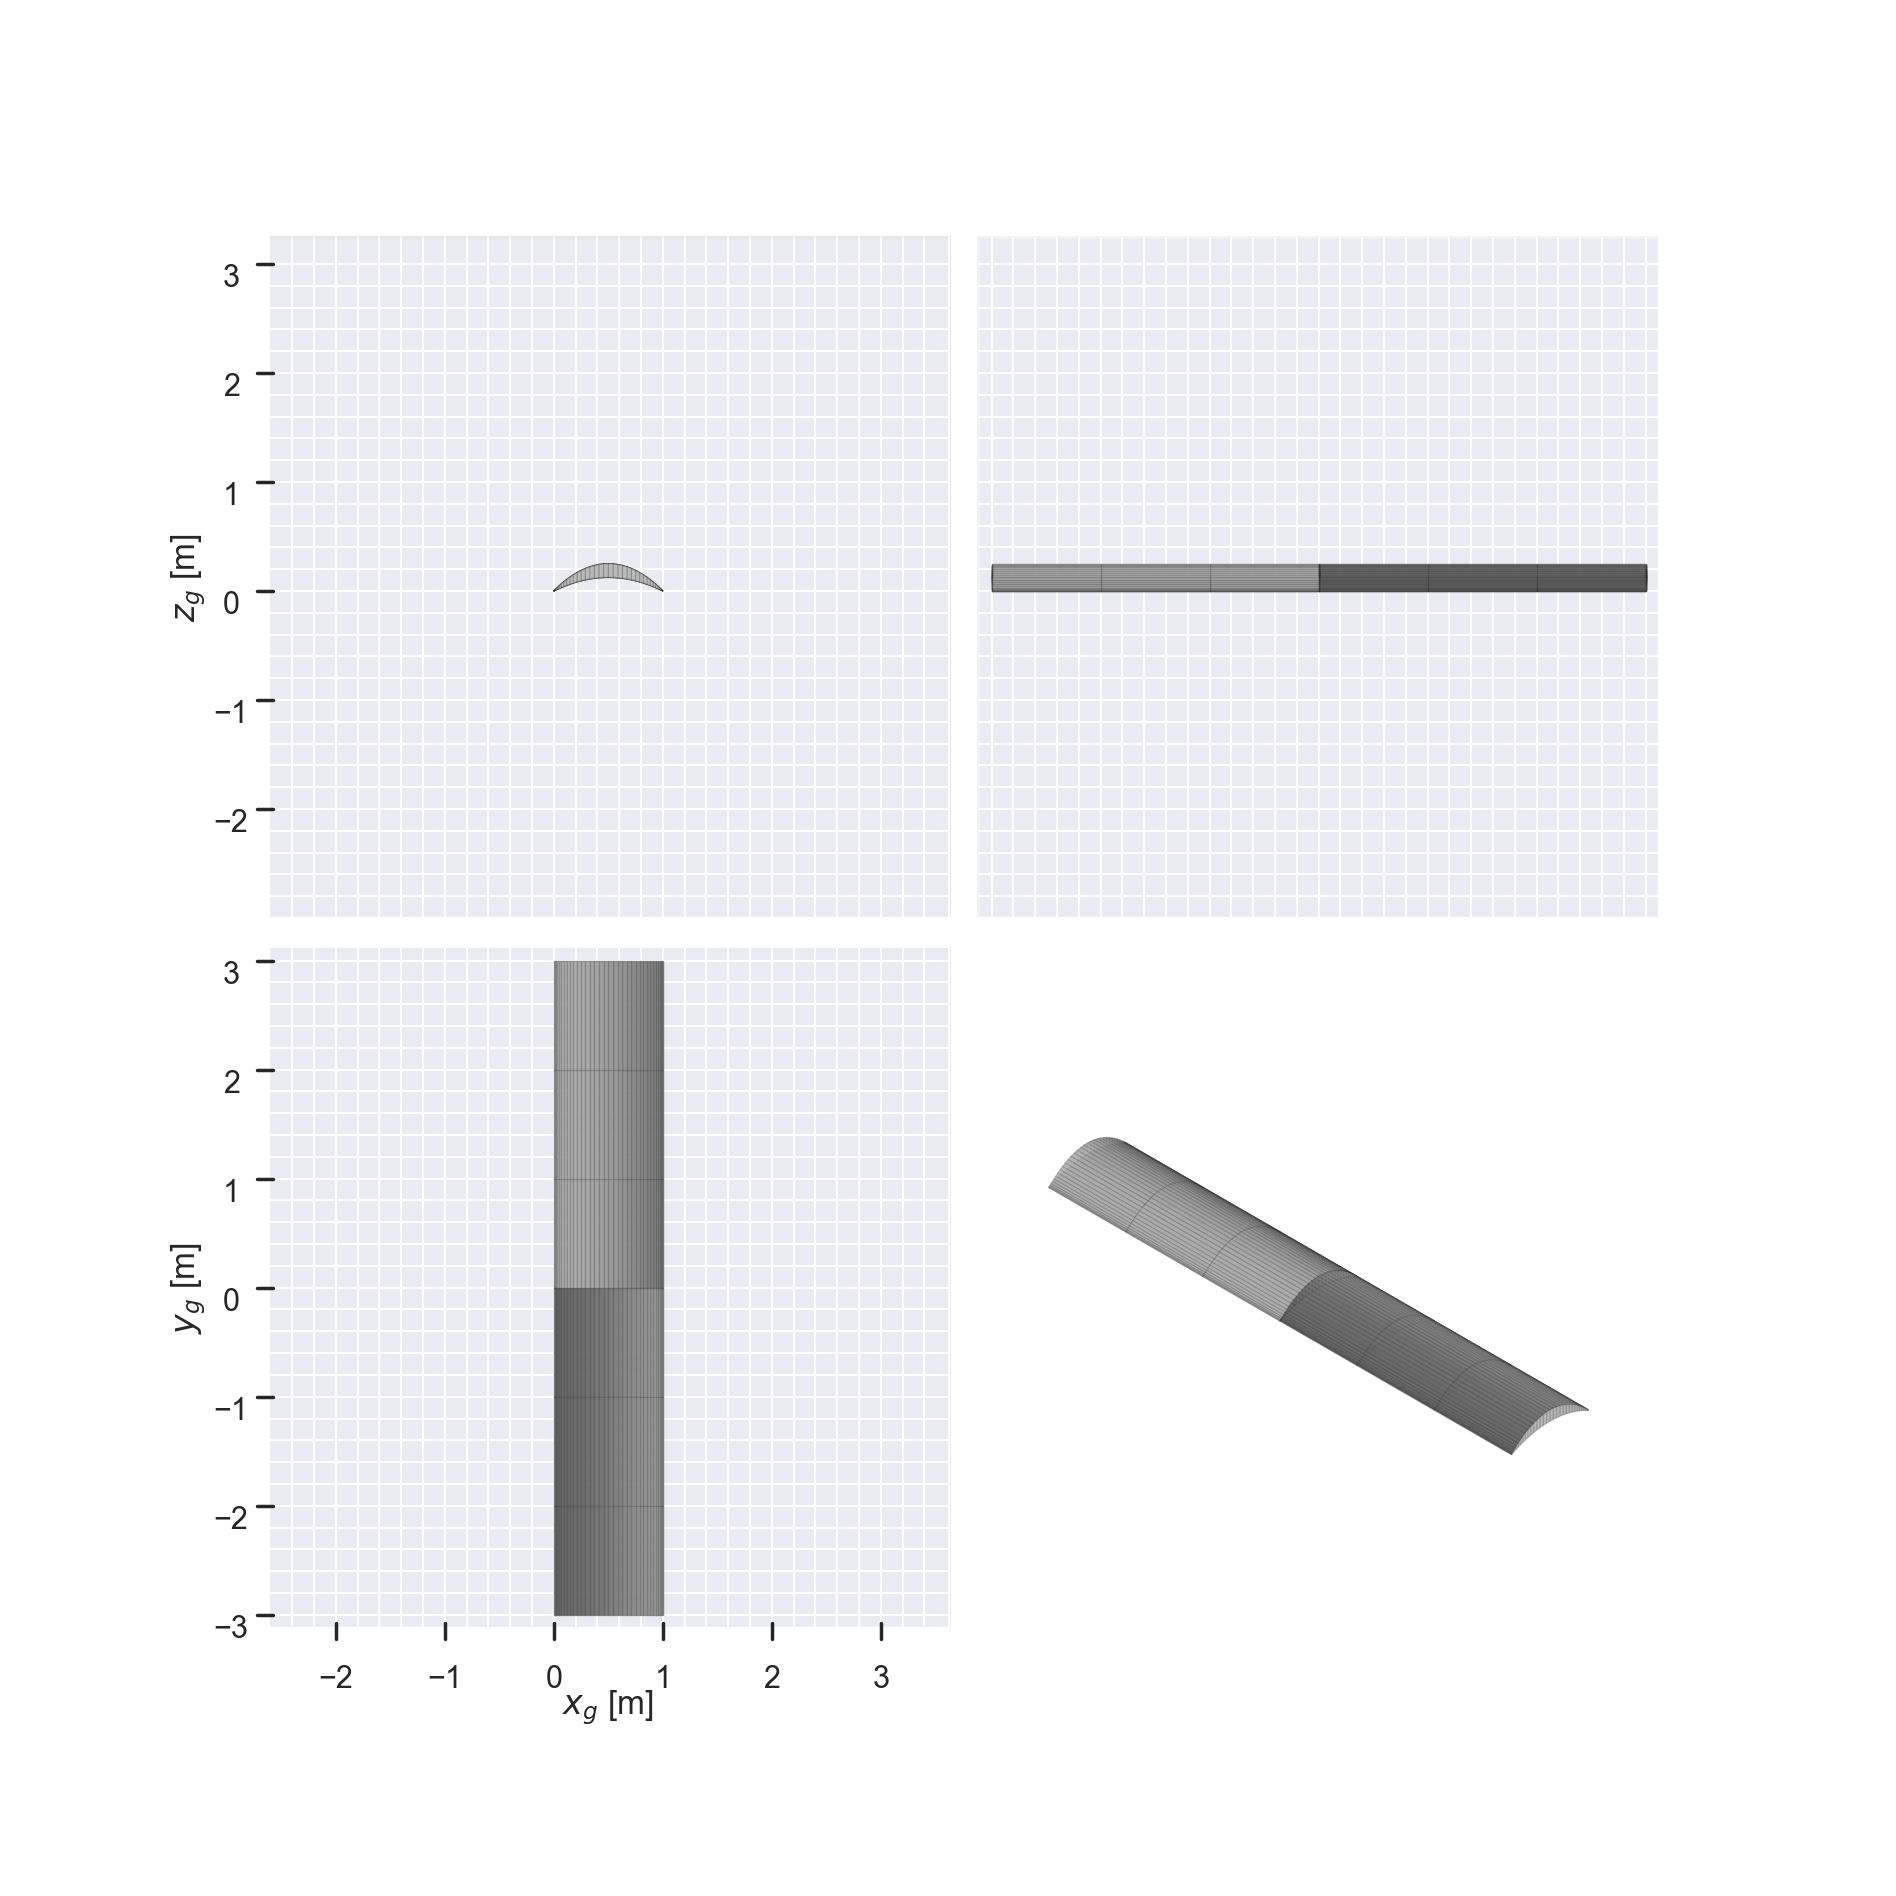

/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


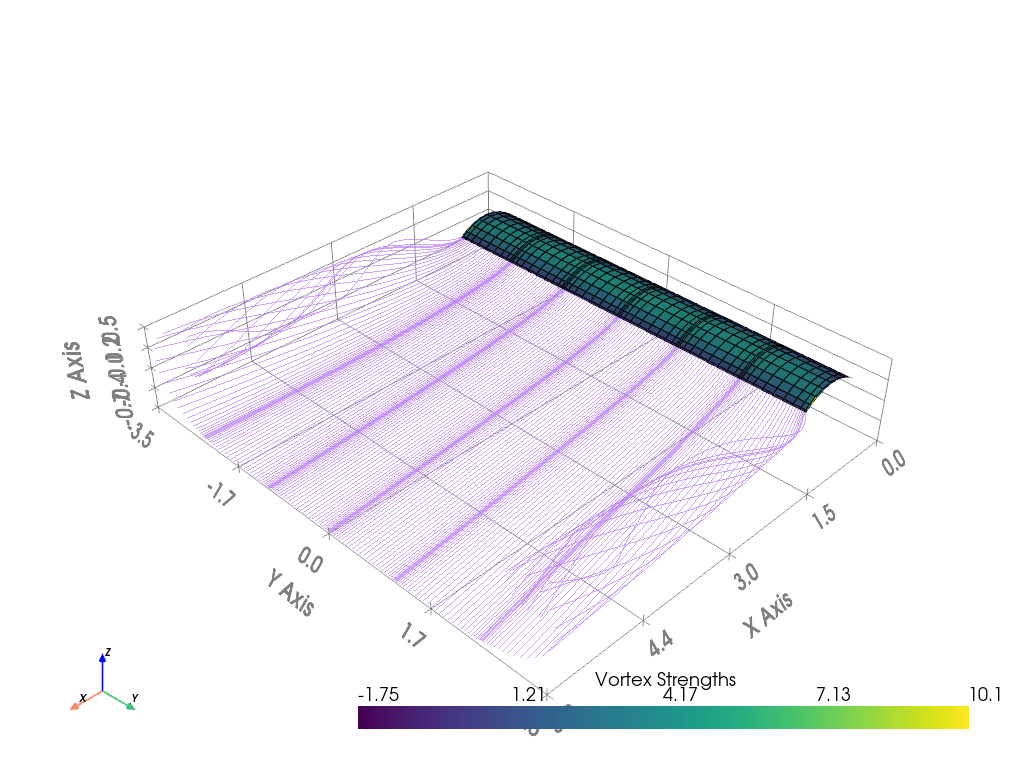

In [13]:
numChords=4, initialYSpacing=0.5, initialChordLength=1, initialUpperKulfan=2, initialLowerKulfan=-0.1, initialLEW=1, initialN1=1, initialN2=1, dX_bounds = (-0.2, 0.2),
		dY_bounds = (-0.2, 0.2),
		dZ_bounds = (-0.2, 0.2),
		dChord_bounds = (-0.2, 0.2),
		dTwist_bounds = (-9, 9),
		KT_bounds = (0, 5),
		KB_bounds = (-3, 0),
		N_bounds = (1, 4),
		LEW_bounds = (0, 1),
		kulfanWeightResolution = 6





env = AeroEnv()
episodes = 50
obs = env.reset()
random_action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(random_action)
obs, reward, terminated, truncated, info = env.step(random_action)
obs, reward, terminated, truncated, info = env.step(random_action)
env.render()
print(env.reset())
env.render()


In [5]:
!{sys.executable} -m pip install 'stable_baselines3[extra]'

Defaulting to user installation because normal site-packages is not writeable
  Using cached Shimmy-1.1.0-py3-none-any.whl (37 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 0.2.1
    Uninstalling Shimmy-0.2.1:
      Successfully uninstalled Shimmy-0.2.1
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [10]:
from stable_baselines3 import PPO
import os
import time

models_dir = f"models/A2C-{int(time.time())}"
logdir = f"logs/A2C-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

env = AeroEnv()
env.reset()

model = PPO(
    n_steps=10,
    batch_size=30,
    policy="MlpPolicy",
    env=env, 
    verbose=2)

total_timesteps = 600
model.learn(total_timesteps=total_timesteps, progress_bar=True)

print("We lerned")

num_episodes = 5
for _ in range(num_episodes):
    obs = env.reset()
    done = False
    while not done:
        action = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        env.render()
env.close()


Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------
| time/              |    |
|    fps             | 6  |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 10 |
---------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 6         |
|    iterations           | 2         |
|    time_elapsed         | 3         |
|    total_timesteps      | 20        |
| train/                  |           |
|    approx_kl            | 0.6549334 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | -114      |
|    explained_variance   | -0.286    |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0446   |
|    n_updates            | 10        |
|    policy_gradient_loss | -0.146    |
|    std                  | 1         |
|    value_loss           | 0.304     |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 6         |
|    iterations           | 3         |
|    time_elapsed         | 4         |
|    total_timesteps      | 30        |
| train/                  |           |
|    approx_kl            | 0.5840151 |
|    clip_fraction        | 0.63      |
|    clip_range           | 0.2       |
|    entropy_loss         | -113      |
|    explained_variance   | -0.696    |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0435    |
|    n_updates            | 20        |
|    policy_gradient_loss | -0.108    |
|    std                  | 1         |
|    value_loss           | 0.438     |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 40          |
| train/                  |             |
|    approx_kl            | 0.087251104 |
|    clip_fraction        | 0.3         |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | -0.265      |
|    learning_rate        | 0.0003      |
|    loss                 | 16.2        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0903     |
|    std                  | 1           |
|    value_loss           | 33.8        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 6          |
|    iterations           | 5          |
|    time_elapsed         | 7          |
|    total_timesteps      | 50         |
| train/                  |            |
|    approx_kl            | 0.31665105 |
|    clip_fraction        | 0.48       |
|    clip_range           | 0.2        |
|    entropy_loss         | -113       |
|    explained_variance   | -0.0255    |
|    learning_rate        | 0.0003     |
|    loss                 | 34.6       |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.0909    |
|    std                  | 1          |
|    value_loss           | 70.4       |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 6          |
|    time_elapsed         | 8          |
|    total_timesteps      | 60         |
| train/                  |            |
|    approx_kl            | 0.15397319 |
|    clip_fraction        | 0.46       |
|    clip_range           | 0.2        |
|    entropy_loss         | -113       |
|    explained_variance   | -0.0302    |
|    learning_rate        | 0.0003     |
|    loss                 | 93.8       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.104     |
|    std                  | 1          |
|    value_loss           | 192        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 7          |
|    time_elapsed         | 9          |
|    total_timesteps      | 70         |
| train/                  |            |
|    approx_kl            | 0.12293609 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -113       |
|    explained_variance   | 0.00638    |
|    learning_rate        | 0.0003     |
|    loss                 | 506        |
|    n_updates            | 60         |
|    policy_gradient_loss | -0.0849    |
|    std                  | 1          |
|    value_loss           | 1.02e+03   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 8          |
|    time_elapsed         | 11         |
|    total_timesteps      | 80         |
| train/                  |            |
|    approx_kl            | 0.44521204 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -0.381     |
|    learning_rate        | 0.0003     |
|    loss                 | 2.99       |
|    n_updates            | 70         |
|    policy_gradient_loss | -0.123     |
|    std                  | 1          |
|    value_loss           | 6.45       |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 7         |
|    iterations           | 9         |
|    time_elapsed         | 12        |
|    total_timesteps      | 90        |
| train/                  |           |
|    approx_kl            | 0.5520996 |
|    clip_fraction        | 0.75      |
|    clip_range           | 0.2       |
|    entropy_loss         | -114      |
|    explained_variance   | -0.0648   |
|    learning_rate        | 0.0003    |
|    loss                 | 3.12      |
|    n_updates            | 80        |
|    policy_gradient_loss | -0.147    |
|    std                  | 1         |
|    value_loss           | 7.15      |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 10         |
|    time_elapsed         | 14         |
|    total_timesteps      | 100        |
| train/                  |            |
|    approx_kl            | 0.40567574 |
|    clip_fraction        | 0.69       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -0.197     |
|    learning_rate        | 0.0003     |
|    loss                 | 14.8       |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.134     |
|    std                  | 1          |
|    value_loss           | 31.4       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 11          |
|    time_elapsed         | 15          |
|    total_timesteps      | 110         |
| train/                  |             |
|    approx_kl            | 0.090681195 |
|    clip_fraction        | 0.41        |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.00115     |
|    learning_rate        | 0.0003      |
|    loss                 | 91.8        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.11       |
|    std                  | 1           |
|    value_loss           | 192         |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 12         |
|    time_elapsed         | 16         |
|    total_timesteps      | 120        |
| train/                  |            |
|    approx_kl            | 0.10008719 |
|    clip_fraction        | 0.39       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | 0.0198     |
|    learning_rate        | 0.0003     |
|    loss                 | 94.7       |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.107     |
|    std                  | 1          |
|    value_loss           | 199        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 13         |
|    time_elapsed         | 17         |
|    total_timesteps      | 130        |
| train/                  |            |
|    approx_kl            | 0.09297222 |
|    clip_fraction        | 0.41       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | 0.0165     |
|    learning_rate        | 0.0003     |
|    loss                 | 84.4       |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.107     |
|    std                  | 1          |
|    value_loss           | 178        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 14         |
|    time_elapsed         | 19         |
|    total_timesteps      | 140        |
| train/                  |            |
|    approx_kl            | 0.05202055 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | 0.0512     |
|    learning_rate        | 0.0003     |
|    loss                 | 426        |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.0757    |
|    std                  | 1          |
|    value_loss           | 870        |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 7         |
|    iterations           | 15        |
|    time_elapsed         | 20        |
|    total_timesteps      | 150       |
| train/                  |           |
|    approx_kl            | 0.1034652 |
|    clip_fraction        | 0.39      |
|    clip_range           | 0.2       |
|    entropy_loss         | -114      |
|    explained_variance   | -0.0432   |
|    learning_rate        | 0.0003    |
|    loss                 | 189       |
|    n_updates            | 140       |
|    policy_gradient_loss | -0.103    |
|    std                  | 1         |
|    value_loss           | 387       |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 16         |
|    time_elapsed         | 21         |
|    total_timesteps      | 160        |
| train/                  |            |
|    approx_kl            | 0.10948996 |
|    clip_fraction        | 0.4        |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | 0.0103     |
|    learning_rate        | 0.0003     |
|    loss                 | 48.8       |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.108     |
|    std                  | 1          |
|    value_loss           | 102        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 17         |
|    time_elapsed         | 22         |
|    total_timesteps      | 170        |
| train/                  |            |
|    approx_kl            | 0.15220289 |
|    clip_fraction        | 0.45       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -0.0154    |
|    learning_rate        | 0.0003     |
|    loss                 | 69.4       |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.113     |
|    std                  | 1          |
|    value_loss           | 144        |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 18          |
|    time_elapsed         | 24          |
|    total_timesteps      | 180         |
| train/                  |             |
|    approx_kl            | 0.070742786 |
|    clip_fraction        | 0.3         |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | -0.00392    |
|    learning_rate        | 0.0003      |
|    loss                 | 140         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0931     |
|    std                  | 1           |
|    value_loss           | 286         |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 19         |
|    time_elapsed         | 25         |
|    total_timesteps      | 190        |
| train/                  |            |
|    approx_kl            | 0.07963938 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | 0.00885    |
|    learning_rate        | 0.0003     |
|    loss                 | 321        |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.102     |
|    std                  | 1          |
|    value_loss           | 650        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 20         |
|    time_elapsed         | 26         |
|    total_timesteps      | 200        |
| train/                  |            |
|    approx_kl            | 0.08180387 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -0.0138    |
|    learning_rate        | 0.0003     |
|    loss                 | 364        |
|    n_updates            | 190        |
|    policy_gradient_loss | -0.0997    |
|    std                  | 1          |
|    value_loss           | 736        |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 21          |
|    time_elapsed         | 28          |
|    total_timesteps      | 210         |
| train/                  |             |
|    approx_kl            | 0.051646806 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.00137     |
|    learning_rate        | 0.0003      |
|    loss                 | 350         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0887     |
|    std                  | 1           |
|    value_loss           | 707         |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 22         |
|    time_elapsed         | 29         |
|    total_timesteps      | 220        |
| train/                  |            |
|    approx_kl            | 0.08533341 |
|    clip_fraction        | 0.35       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 276        |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.101     |
|    std                  | 1          |
|    value_loss           | 558        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 23         |
|    time_elapsed         | 30         |
|    total_timesteps      | 230        |
| train/                  |            |
|    approx_kl            | 0.06656863 |
|    clip_fraction        | 0.29       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | 0.00255    |
|    learning_rate        | 0.0003     |
|    loss                 | 385        |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.0941    |
|    std                  | 1          |
|    value_loss           | 778        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 24         |
|    time_elapsed         | 32         |
|    total_timesteps      | 240        |
| train/                  |            |
|    approx_kl            | 0.27153924 |
|    clip_fraction        | 0.53       |
|    clip_range           | 0.2        |
|    entropy_loss         | -113       |
|    explained_variance   | 0.152      |
|    learning_rate        | 0.0003     |
|    loss                 | 91.6       |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.122     |
|    std                  | 1          |
|    value_loss           | 186        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 25         |
|    time_elapsed         | 34         |
|    total_timesteps      | 250        |
| train/                  |            |
|    approx_kl            | 0.36784443 |
|    clip_fraction        | 0.59       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -6.22      |
|    learning_rate        | 0.0003     |
|    loss                 | 81.3       |
|    n_updates            | 240        |
|    policy_gradient_loss | -0.13      |
|    std                  | 1          |
|    value_loss           | 164        |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 26          |
|    time_elapsed         | 35          |
|    total_timesteps      | 260         |
| train/                  |             |
|    approx_kl            | 0.056903742 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.012       |
|    learning_rate        | 0.0003      |
|    loss                 | 990         |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.1        |
|    std                  | 1           |
|    value_loss           | 1.99e+03    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 27         |
|    time_elapsed         | 36         |
|    total_timesteps      | 270        |
| train/                  |            |
|    approx_kl            | 0.16417071 |
|    clip_fraction        | 0.46       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -0.389     |
|    learning_rate        | 0.0003     |
|    loss                 | 711        |
|    n_updates            | 260        |
|    policy_gradient_loss | -0.116     |
|    std                  | 1          |
|    value_loss           | 1.43e+03   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 28         |
|    time_elapsed         | 38         |
|    total_timesteps      | 280        |
| train/                  |            |
|    approx_kl            | 0.14625935 |
|    clip_fraction        | 0.46       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -0.353     |
|    learning_rate        | 0.0003     |
|    loss                 | 180        |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.11      |
|    std                  | 1          |
|    value_loss           | 371        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 29         |
|    time_elapsed         | 39         |
|    total_timesteps      | 290        |
| train/                  |            |
|    approx_kl            | 0.46038303 |
|    clip_fraction        | 0.64       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -0.0637    |
|    learning_rate        | 0.0003     |
|    loss                 | 65.5       |
|    n_updates            | 280        |
|    policy_gradient_loss | -0.133     |
|    std                  | 1          |
|    value_loss           | 136        |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 7         |
|    iterations           | 30        |
|    time_elapsed         | 40        |
|    total_timesteps      | 300       |
| train/                  |           |
|    approx_kl            | 1.1590192 |
|    clip_fraction        | 0.79      |
|    clip_range           | 0.2       |
|    entropy_loss         | -114      |
|    explained_variance   | 0.0887    |
|    learning_rate        | 0.0003    |
|    loss                 | 4.52      |
|    n_updates            | 290       |
|    policy_gradient_loss | -0.146    |
|    std                  | 1         |
|    value_loss           | 10.8      |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 31         |
|    time_elapsed         | 42         |
|    total_timesteps      | 310        |
| train/                  |            |
|    approx_kl            | 0.45865327 |
|    clip_fraction        | 0.72       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -1.18      |
|    learning_rate        | 0.0003     |
|    loss                 | 6.4        |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.14      |
|    std                  | 1          |
|    value_loss           | 15.8       |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 7         |
|    iterations           | 32        |
|    time_elapsed         | 43        |
|    total_timesteps      | 320       |
| train/                  |           |
|    approx_kl            | 0.9377326 |
|    clip_fraction        | 0.68      |
|    clip_range           | 0.2       |
|    entropy_loss         | -114      |
|    explained_variance   | -0.767    |
|    learning_rate        | 0.0003    |
|    loss                 | 9.25      |
|    n_updates            | 310       |
|    policy_gradient_loss | -0.138    |
|    std                  | 1         |
|    value_loss           | 22.4      |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 7         |
|    iterations           | 33        |
|    time_elapsed         | 44        |
|    total_timesteps      | 330       |
| train/                  |           |
|    approx_kl            | 0.4905049 |
|    clip_fraction        | 0.58      |
|    clip_range           | 0.2       |
|    entropy_loss         | -114      |
|    explained_variance   | -1.32     |
|    learning_rate        | 0.0003    |
|    loss                 | 9.37      |
|    n_updates            | 320       |
|    policy_gradient_loss | -0.12     |
|    std                  | 1         |
|    value_loss           | 22.3      |
---------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 7        |
|    iterations           | 34       |
|    time_elapsed         | 45       |
|    total_timesteps      | 340      |
| train/                  |          |
|    approx_kl            | 1.213952 |
|    clip_fraction        | 0.76     |
|    clip_range           | 0.2      |
|    entropy_loss         | -114     |
|    explained_variance   | -0.444   |
|    learning_rate        | 0.0003   |
|    loss                 | 5.6      |
|    n_updates            | 330      |
|    policy_gradient_loss | -0.143   |
|    std                  | 1        |
|    value_loss           | 12.8     |
--------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 7         |
|    iterations           | 35        |
|    time_elapsed         | 47        |
|    total_timesteps      | 350       |
| train/                  |           |
|    approx_kl            | 0.4854587 |
|    clip_fraction        | 0.58      |
|    clip_range           | 0.2       |
|    entropy_loss         | -114      |
|    explained_variance   | -55.5     |
|    learning_rate        | 0.0003    |
|    loss                 | 38.9      |
|    n_updates            | 340       |
|    policy_gradient_loss | -0.115    |
|    std                  | 1         |
|    value_loss           | 81.9      |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 36         |
|    time_elapsed         | 48         |
|    total_timesteps      | 360        |
| train/                  |            |
|    approx_kl            | 0.52971125 |
|    clip_fraction        | 0.68       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -18.8      |
|    learning_rate        | 0.0003     |
|    loss                 | 60.9       |
|    n_updates            | 350        |
|    policy_gradient_loss | -0.137     |
|    std                  | 1          |
|    value_loss           | 123        |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 37         |
|    time_elapsed         | 50         |
|    total_timesteps      | 370        |
| train/                  |            |
|    approx_kl            | 0.42355675 |
|    clip_fraction        | 0.59       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -22.8      |
|    learning_rate        | 0.0003     |
|    loss                 | 42.1       |
|    n_updates            | 360        |
|    policy_gradient_loss | -0.11      |
|    std                  | 1          |
|    value_loss           | 87.2       |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 7         |
|    iterations           | 38        |
|    time_elapsed         | 51        |
|    total_timesteps      | 380       |
| train/                  |           |
|    approx_kl            | 1.3405712 |
|    clip_fraction        | 0.8       |
|    clip_range           | 0.2       |
|    entropy_loss         | -114      |
|    explained_variance   | -0.0316   |
|    learning_rate        | 0.0003    |
|    loss                 | 11.6      |
|    n_updates            | 370       |
|    policy_gradient_loss | -0.144    |
|    std                  | 1         |
|    value_loss           | 23.7      |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 39         |
|    time_elapsed         | 52         |
|    total_timesteps      | 390        |
| train/                  |            |
|    approx_kl            | 0.36697733 |
|    clip_fraction        | 0.62       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -15        |
|    learning_rate        | 0.0003     |
|    loss                 | 45.8       |
|    n_updates            | 380        |
|    policy_gradient_loss | -0.134     |
|    std                  | 1          |
|    value_loss           | 95.2       |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 40         |
|    time_elapsed         | 54         |
|    total_timesteps      | 400        |
| train/                  |            |
|    approx_kl            | 0.38374072 |
|    clip_fraction        | 0.62       |
|    clip_range           | 0.2        |
|    entropy_loss         | -114       |
|    explained_variance   | -28.6      |
|    learning_rate        | 0.0003     |
|    loss                 | 48.2       |
|    n_updates            | 390        |
|    policy_gradient_loss | -0.121     |
|    std                  | 1          |
|    value_loss           | 101        |
----------------------------------------


We lerned


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.